<a href="https://colab.research.google.com/github/havihaviplants/Machine-learning/blob/main/new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [ ]:
# 자신의 Google Drive 마운트하는 코드를 추가하자!
mnist = np.load('/content/drive/MyDrive/MY Drive/mnist.npz')
x_train = (mnist['x_train'] - np.mean(mnist['x_train'])) / np.std(mnist['x_train'])
y_train = mnist['y_train']
x_test = (mnist['x_test'] - np.mean(mnist['x_train'])) / np.std(mnist['x_train'])
y_test = mnist['y_test']
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [ ]:
from torch.utils.data import DataLoader
batch_size = 16
train_dataloader = DataLoader(torch.FloatTensor(x_train), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(torch.FloatTensor(x_test), batch_size=batch_size, shuffle=False)


In [ ]:
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
 nn.Linear(28 * 28, 128),
 nn.ReLU(),
 nn.Linear(128, 64),
 nn.ReLU(),
 nn.Linear(64, 32),
 )
    self.decoder = nn.Sequential(
 nn.Linear(32, 64),
 nn.ReLU(),
 nn.Linear(64, 128),
 nn.ReLU(),
 nn.Linear(128, 28 * 28),
 )

    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)

      return decoded


In [ ]:
class CNN_Autoencoder(nn.Module):
 def __init__(self):
  super().__init__()
  self.encoder = nn.Sequential(
 nn.Conv2d(1, 16, 3, stride=2, padding=1),
 nn.ReLU(),
 nn.Conv2d(16, 32, 3, stride=2, padding=1),
 nn.ReLU(),
 nn.Conv2d(32, 64, 7),
 )
  self.decoder = nn.Sequential(
 nn.ConvTranspose2d(64, 32, 7),
 nn.ReLU(),
 nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
 nn.ReLU(),
 nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
 )

 def forward(self, x):
  encoded = self.encoder(x)
  decoded = self.decoder(encoded)

  return decoded


In [ ]:
from torch.optim import Adam
#model = Autoencoder().to(device)
model = CNN_Autoencoder().to(device)
criterion = nn.L1Loss().to(device)
opti = Adam(model.parameters(), lr=1e-4)

In [ ]:
def add_noise(clean, noise_factor=0.2):
 noisy = clean + torch.randn_like(clean) * noise_factor

 return noisy

In [ ]:
def train(model, dataloader, criterion, data_len, opti):
 train_loss = 0

 model.train()
 for data in dataloader:
 #data = data.view(-1, 28 * 28).to(device)
  data = data.view(-1, 1, 28, 28).to(device)
 noisy = add_noise(data)
 #target = data.view(-1, 28 * 28).to(device)
 target = data.view(-1, 1, 28, 28).to(device)

 output = model(noisy)
 loss = criterion(output, target)

 opti.zero_grad()
 loss.backward()
 opti.step()

 train_loss += loss.item()

 return train_loss / len(dataloader)

In [ ]:
def evaluate(model, dataloader, criterion, data_len):
 eval_loss = 0

 model.eval()
 for data in dataloader:
 #data = data.view(-1, 28 * 28).to(device)
  data = data.view(-1, 1, 28, 28).to(device)
 noisy = add_noise(data)
 #target = data.view(-1, 28 * 28).to(device)
 target = data.view(-1, 1, 28, 28).to(device)

 output = model(noisy)
 loss = criterion(output, target)

 eval_loss += loss.item()

 return eval_loss / len(dataloader)


In [ ]:
epoch = 10
for i in range(epoch):
 train_loss = train(model, train_dataloader, criterion, len(train_dataloader.dataset), opti)
 val_loss = evaluate(model, test_dataloader, criterion, len(test_dataloader.dataset))
 print(f"[Epoch: {i:2d}], [Train Loss: {train_loss:1.6f}], [Val Acc: {val_loss:1.6f}]")

[Epoch:  0], [Train Loss: 0.000127], [Val Acc: 0.000975]
[Epoch:  1], [Train Loss: 0.000120], [Val Acc: 0.000974]
[Epoch:  2], [Train Loss: 0.000132], [Val Acc: 0.000974]
[Epoch:  3], [Train Loss: 0.000130], [Val Acc: 0.000973]
[Epoch:  4], [Train Loss: 0.000121], [Val Acc: 0.000972]
[Epoch:  5], [Train Loss: 0.000141], [Val Acc: 0.000972]
[Epoch:  6], [Train Loss: 0.000140], [Val Acc: 0.000971]
[Epoch:  7], [Train Loss: 0.000130], [Val Acc: 0.000970]
[Epoch:  8], [Train Loss: 0.000147], [Val Acc: 0.000969]
[Epoch:  9], [Train Loss: 0.000139], [Val Acc: 0.000968]


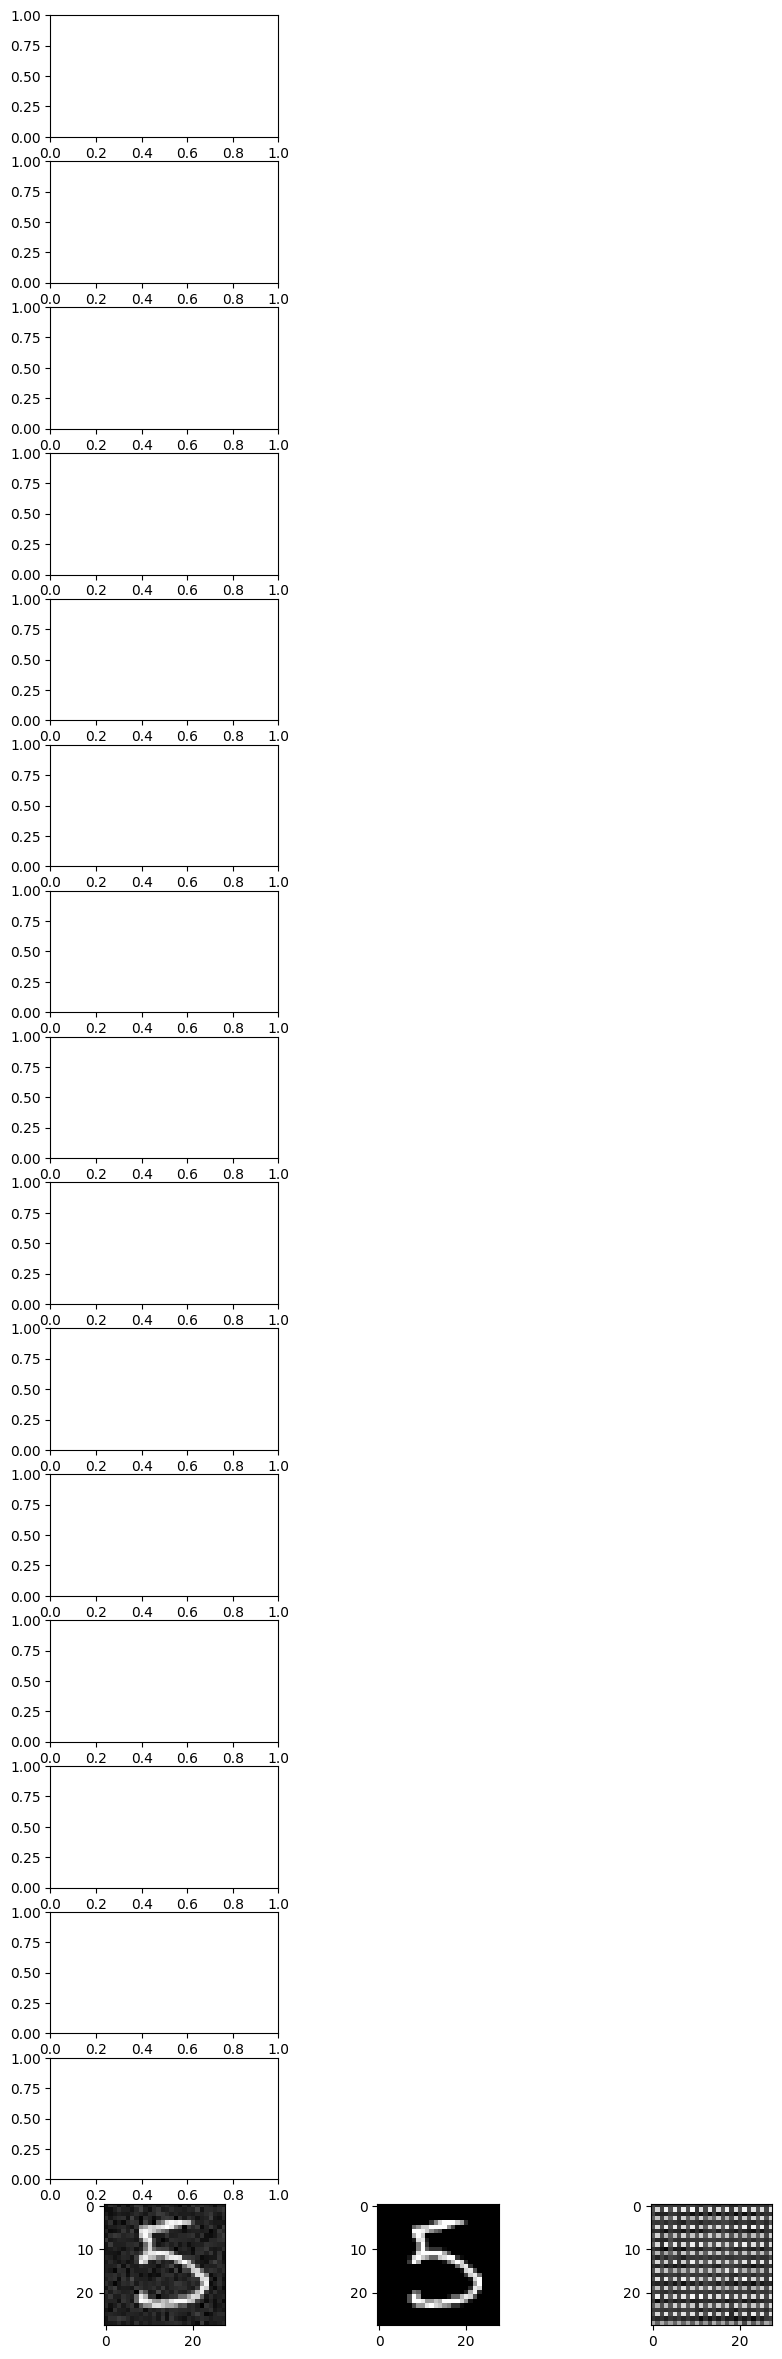

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 30)
for data in test_dataloader:
 #data = data.view(-1, 28 * 28).to(device)
 data = data.view(-1, 1, 28, 28).to(device)
 noisy = add_noise(data)
 #target = data.view(-1, 28 * 28).to(device)
 target = data.view(-1, 1, 28, 28).to(device)

 output = model(data)

 for i in range(batch_size):
  plt.subplot(batch_size, 3, 3*i+1)
 plt.imshow(noisy[i].view(28, 28).detach().cpu().numpy(), cmap="gray")

 plt.subplot(batch_size, 3, 3*i+2)
 plt.imshow(target[i].view(28, 28).detach().cpu().numpy(), cmap="gray")

 plt.subplot(batch_size, 3, 3*i+3)
 plt.imshow(output[i].view(28, 28).detach().cpu().numpy(), cmap="gray")
 plt.show()

 break
